In [1]:
import os
os.chdir("..")

In [14]:
from humseg.lit_module import LitSegmentation
from humseg.dataset import HumsegDataModule
import os
import omegaconf
from glob import glob
import argparse
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
model_path = "./outputs/resnet34_basic"

In [6]:
checkpoint_path = glob(os.path.join(model_path, "checkpoints/*.ckpt"))[
    0
]

config_path = os.path.join(model_path, ".hydra/config.yaml")
model = LitSegmentation.load_from_checkpoint(
    checkpoint_path=checkpoint_path
)

cfg = omegaconf.OmegaConf.load(config_path)
dm = HumsegDataModule(cfg)
dm.setup("test")

In [116]:
predictions = []
test_img = None

flag = True

for batch in dm.test_dataloader():
    y = model(batch)
    
    if flag:
        test_img = batch
        flag = False

    y = torch.sigmoid(
        torch.nn.functional.interpolate(
            y,
            size=(320, 240), 
            mode="bilinear"
        )
    )
    
    y = (y > 0.5).type(y.dtype)

    y = y.detach().numpy().squeeze()

    predictions.append(y)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [117]:
predictions = np.concatenate(predictions, axis=0)

In [118]:
predictions[0].shape

(320, 240)

In [119]:
test_img.shape

torch.Size([24, 3, 224, 224])

In [120]:
test_img = torch.nn.functional.interpolate(
    test_img,
    size=(320, 240),  # mode="bilinear"
)

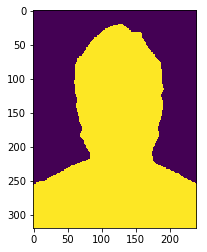

In [121]:
plt.imshow(predictions[0])

In [122]:
test_img[0].permute([1, 2, 0]).detach().numpy().squeeze().shape

(320, 240, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


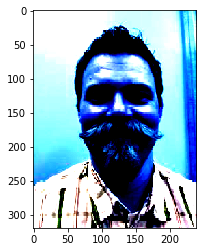

In [123]:
plt.imshow(test_img[0].permute([1, 2, 0]).detach().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


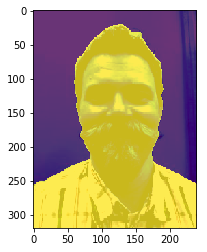

In [124]:
plt.imshow(test_img[0].permute([1, 2, 0]).detach().numpy().squeeze())
plt.imshow(predictions[0], alpha=0.8)

In [115]:
cv2.imwrite(
    "test.jpg",
    predictions[0] * 255,
)

True